<a href="https://colab.research.google.com/github/brndiogo/brndiogo-iIoT-Garbage-Management-Monitoring-and-Acknowledgment-System-Review/blob/main/colab_teste1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Instala a biblioteca do Kaggle
!pip install kaggle
# 2. Pede para você fazer o upload do seu arquivo kaggle.json
from google.colab import files
print("--- Por favor, faça o upload do seu arquivo kaggle.json ---")
files.upload()
# 3. Configura o arquivo kaggle.json no lugar certo
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# 4. Baixa o Dataset "Waste Classification data" (2 classes: Orgânico e Reciclável)
print("\n--- Baixando o dataset do Kaggle... ---")
!kaggle datasets download -d techsash/waste-classification-data
# 5. Descompacta o dataset (ele cria uma pasta chamada 'dataset')
print("--- Descompactando arquivos... ---")
!unzip -q waste-classification-data.zip -d dataset
print("\n--- PRONTO! O dataset está em /content/dataset/ ---")


--- Por favor, faça o upload do seu arquivo kaggle.json ---


Saving kaggle.json to kaggle.json

--- Baixando o dataset do Kaggle... ---
Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data
License(s): CC-BY-SA-4.0
 93% 399M/427M [00:02<00:00, 111MB/s]
100% 427M/427M [00:02<00:00, 162MB/s]
--- Descompactando arquivos... ---

--- PRONTO! O dataset está em /content/dataset/ ---


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# --- 1. Configuração do Experimento (MUDANÇA AQUI) ---
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CLASSES = 6   # MUDANÇA: Agora temos 6 classes
BATCH_SIZE = 32
TOTAL_EPOCHS = 30 # 30 épocas continua sendo um bom teste

# Caminho para os dados que baixamos no Bloco 1
DATA_PATH = 'Garbage classification' # MUDANÇA: O nome da pasta

# --- 2. Carregar os Dados Reais (MUDANÇA GRANDE AQUI) ---
# Este dataset não tem separação de treino/validação, então criamos uma (80/20).

print("--- Carregando dataset de TREINO (80%)... ---")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,  # Define que 20% dos dados serão para validação
    subset='training',     # Define este como o conjunto de TREINO
    seed=123               # Semente para garantir que os dados não se misturem
)

print("--- Carregando dataset de VALIDAÇÃO (20%)... ---")
val_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,  # Mesma separação de 20%
    subset='validation',   # Define este como o conjunto de VALIDAÇÃO
    seed=123               # MESMA semente para garantir que não há sobreposição
)

# Otimização: Pré-carregar dados para a GPU
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Calcula o número de passos de treinamento por época
STEPS_PER_EPOCH = len(train_dataset)


# --- 3. Função para Criar o Modelo (MobileNetV2) ---
# (O código aqui é idêntico ao anterior, mas a camada final
# será automaticamente ajustada para NUM_CLASSES = 6)
def criar_modelo():
    base_modelo = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
        include_top=False,
        weights='imagenet'
    )
    base_modelo.trainable = False

    modelo = tf.keras.Sequential([
        layers.Rescaling(1./255),
        base_modelo,
        layers.GlobalAveragePooling2D(),
        layers.Dense(NUM_CLASSES, activation='softmax') # Automaticamente usará 6 classes
    ])
    return modelo

# --- 4. Experimento A: "Rampa" (Step Decay) ---
print("\n--- Iniciando Experimento A (RAMPA / STEP DECAY) ---")

modelo_rampa = criar_modelo()

lr_schedule_rampa = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[STEPS_PER_EPOCH * 10, STEPS_PER_EPOCH * 20],
    values=[0.001, 0.0005, 0.0001]
)

modelo_rampa.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_rampa),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_rampa = modelo_rampa.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 5. Experimento B: "Cosseno" (Cosine Decay) ---
print("\n--- Iniciando Experimento B (COSSENO / COSINE DECAY) ---")

modelo_cosseno = criar_modelo() # CRÍTICO: Crie um modelo novo!

total_decay_steps = STEPS_PER_EPOCH * TOTAL_EPOCHS
lr_schedule_cosseno = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=total_decay_steps
)

modelo_cosseno.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_cosseno),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_cosseno = modelo_cosseno.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 6. Análise: Plotar os Gráficos ---
print("\n--- Plotando Resultados (A Análise) ---")

acc_rampa = history_rampa.history['val_accuracy']
acc_cosseno = history_cosseno.history['val_accuracy']
epocas = range(1, TOTAL_EPOCHS + 1)

plt.figure(figsize=(12, 6))
plt.plot(epocas, acc_rampa, 'b--', label='Acurácia (Rampa / Step Decay)')
plt.plot(epocas, acc_cosseno, 'r-', label='Acurácia (Cosseno / Cosine Decay)')
plt.title('Resultado: Rampa vs. Cosseno (Dataset 6 Classes)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia na Validação')
plt.legend()
plt.grid(True)
plt.show()

# Comparação final
print(f"Acurácia final (Rampa):   {acc_rampa[-1]:.4f}")
print(f"Acurácia final (Cosseno): {acc_cosseno[-1]:.4f}")

--- Carregando dataset de TREINO (80%)... ---


NotFoundError: Could not find directory Garbage classification

--- Carregando datasets... ---
Found 22564 files belonging to 2 classes.
Found 2513 files belonging to 2 classes.

--- Iniciando Experimento A (RAMPA / STEP DECAY) ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 61s 64ms/step - accuracy: 0.8685 - loss: 0.3111 - val_accuracy: 0.9152 - val_loss: 0.2156
Epoch 2/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9216 - loss: 0.2037 - val_accuracy: 0.9121 - val_loss: 0.2256
Epoch 3/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9279 - loss: 0.1878 - val_accuracy: 0.9073 - val_loss: 0.2349
Epoch 4/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9302 - loss: 0.1804 - val_accuracy: 0.9073 - val_loss: 0.2422
Epoch 5/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9316 - loss: 0.1766 - val_accuracy: 0.9045 - val_loss: 0.2483
Epoch 6/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9324 - loss: 0.1744 - val_accuracy: 0.9033 - val_loss: 0.2537
Epoch 7/

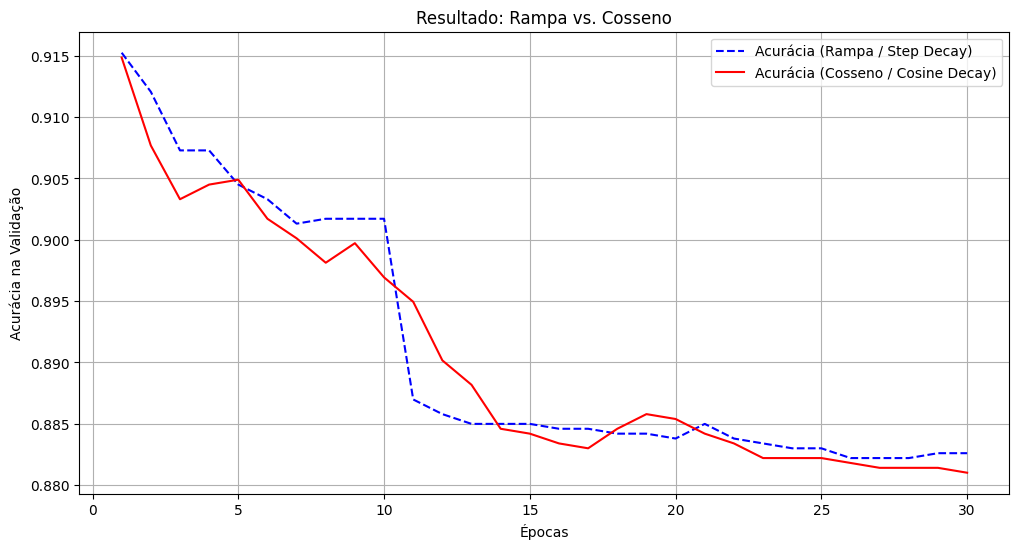

Acurácia final (Rampa): 0.8826
Acurácia final (Cosseno): 0.8810


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
# --- 1. Configuração do Experimento ---
# Este dataset tem 2 classes: 'O' (Orgânico) e 'R' (Reciclável)
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CLASSES = 2
BATCH_SIZE = 32
TOTAL_EPOCHS = 30 # 30 épocas é bom para um teste
# Caminhos para os dados que baixamos no Bloco 1
TRAIN_PATH = 'dataset/DATASET/TRAIN'
VAL_PATH = 'dataset/DATASET/TEST' # Usaremos a pasta 'TEST' como validação
# --- 2. Carregar os Dados Reais ---
print("--- Carregando datasets... ---")
train_dataset = tf.keras.utils.image_dataset_from_directory(
TRAIN_PATH,
image_size=(IMG_WIDTH, IMG_HEIGHT),
batch_size=BATCH_SIZE,
label_mode='int'
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
VAL_PATH,
image_size=(IMG_WIDTH, IMG_HEIGHT),
batch_size=BATCH_SIZE,
label_mode='int'
)
# Otimização: Pré-carregar dados para a GPU
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# Calcula o número de passos de treinamento por época
STEPS_PER_EPOCH = len(train_dataset)
# --- 3. Função para Criar o Modelo (MobileNetV2) ---
def criar_modelo():
    base_modelo = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    include_top=False,
    weights='imagenet'
    )
    base_modelo.trainable = False
    modelo = tf.keras.Sequential([
    layers.Rescaling(1./255), # Normalizar pixels
    base_modelo,
    layers.GlobalAveragePooling2D(),
    layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return modelo
# --- 4. Experimento A: "Rampa" (Step Decay) ---
print("\n--- Iniciando Experimento A (RAMPA / STEP DECAY) ---")
modelo_rampa = criar_modelo()
# Definindo o agendador "Rampa" (cai na época 10 e 20)
lr_schedule_rampa = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
boundaries=[STEPS_PER_EPOCH * 10, STEPS_PER_EPOCH * 20],
values=[0.001, 0.0005, 0.0001]
)
modelo_rampa.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_rampa),
loss='sparse_categorical_crossentropy',
metrics=['accuracy']
)
# Treina o modelo A
history_rampa = modelo_rampa.fit(
train_dataset,
epochs=TOTAL_EPOCHS,
validation_data=val_dataset
)
# --- 5. Experimento B: "Cosseno" (Cosine Decay) ---
print("\n--- Iniciando Experimento B (COSSENO / COSINE DECAY) ---")
modelo_cosseno = criar_modelo() # CRÍTICO: Crie um modelo novo!
# Definindo o agendador "Cosseno"
total_decay_steps = STEPS_PER_EPOCH * TOTAL_EPOCHS
lr_schedule_cosseno = tf.keras.optimizers.schedules.CosineDecay(
initial_learning_rate=0.001,
decay_steps=total_decay_steps
)
modelo_cosseno.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_cosseno),
loss='sparse_categorical_crossentropy',
metrics=['accuracy']
)
# Treina o modelo B
history_cosseno = modelo_cosseno.fit(
train_dataset,
epochs=TOTAL_EPOCHS,
validation_data=val_dataset
)
# --- 6. Análise: Plotar os Gráficos ---
print("\n--- Plotando Resultados (A Análise) ---")
acc_rampa = history_rampa.history['val_accuracy']
acc_cosseno = history_cosseno.history['val_accuracy']
epocas = range(1, TOTAL_EPOCHS + 1)
plt.figure(figsize=(12, 6))
plt.plot(epocas, acc_rampa, 'b--', label='Acurácia (Rampa / Step Decay)')
plt.plot(epocas, acc_cosseno, 'r-', label='Acurácia (Cosseno / Cosine Decay)')
plt.title('Resultado: Rampa vs. Cosseno')
plt.xlabel('Épocas')
plt.ylabel('Acurácia na Validação')
plt.legend()
plt.grid(True)
plt.show()
# Comparação final
print(f"Acurácia final (Rampa): {acc_rampa[-1]:.4f}")
print(f"Acurácia final (Cosseno): {acc_cosseno[-1]:.4f}")